### Import libraries

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

### Load dataset

In [107]:
file_path = "./data/1991-2005/monthly/solar_dataset.csv"
data = pd.read_csv(file_path)

### Data Preprocessing

In [108]:
# # Convert Year and Month into a single feature 'YearMonth'
# data['YearMonth'] = data['Year'].astype(str) + data['Month'].astype(str).str.zfill(2)
# data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y%m')
# 
# # Drop original Year and Month columns
# data = data.drop(['Year', 'Month'], axis=1)

# Feature Scaling for coordinate and solar irradiation inputs
features = ['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']
target = 'Merged Glo (Wh/m^2)'

X = data[features]
y = data[target]

# Normalize/Standardize the coordinate data
scaler = StandardScaler()
X[['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']] = scaler.fit_transform(X[['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']])


C:\Users\Tugay Talha İçen\AppData\Local\Temp\ipykernel_26516\1461843392.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']] = scaler.fit_transform(X[['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']])


### Train Test Validation Split

In [109]:
# Train-Validation-Test Split (60% Train, 20% Validation, 20% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)


### Model Training with XGBoost

In [110]:
xgboost_model = XGBRegressor(n_estimators=350, learning_rate=0.1, max_depth=10, random_state=42)
xgboost_model.fit(X_train, y_train,  verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Prediction and Evaluation of the XGBoost Model

In [111]:
# Prediction and Evaluation on Test Data
y_pred = xgboost_model.predict(X_val)

# Evaluation Metrics on Test Data
mse_test = mean_squared_error(y_val, y_pred)
r2_test = r2_score(y_val, y_pred)

print(f"Mean Squared Error on Test Data: {mse_test}")
print(f"R-squared on Test Data: {r2_test}")

Mean Squared Error on Test Data: 102859818.61830932
R-squared on Test Data: 0.971150019108729


### Retrain the XGboost model on the train+test dataset 

In [112]:
X_train_full = pd.concat([X_train, X_test])
y_train_full = pd.concat([y_train, y_test])
xgboost_model.fit(X_train_full, y_train_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Save the trained model

In [113]:
model_filename = 'xgboost_solar_model.pkl'
joblib.dump(xgboost_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to xgboost_solar_model.pkl


### Plotting Actual vs Predicted

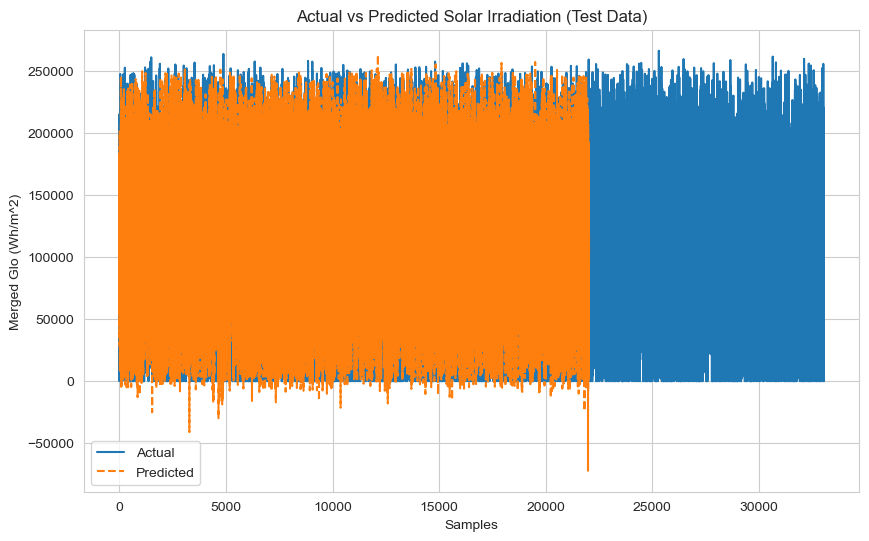

In [114]:
# Plotting Actual vs Predicted on Test Data
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Merged Glo (Wh/m^2)')
plt.title('Actual vs Predicted Solar Irradiation (Test Data)')
plt.show()

In [115]:
#print maximum and minimum predicted values
print("Maximum predicted value:", max(y_pred))
print("Minimum predicted value:", min(y_pred))

Maximum predicted value: 262888.7
Minimum predicted value: -72174.39


In [116]:
# Print number of negative predictions
print("Number of negative predictions:", sum(y_pred < 0), "out of", len(y_pred))

Number of negative predictions: 152 out of 22029


In [117]:
# X values of negative predictions
print("", X_val[y_pred < 0])

         Azimuth (deg)  Longitude  Elevation  Latitude      Year     Month
118823      -0.830226   0.123524   0.020500  0.224482 -1.157298  1.593255
117712       0.912591   0.201985  -0.118606  0.111872 -1.620211 -0.434524
124383       1.101047   0.079390   0.002089  0.161302 -1.388754 -0.724207
3395        -0.934280  -2.848601  -0.756857  2.808593  1.157267  1.593255
120066       0.879794   0.183187  -0.049053  0.232424 -1.388754  0.144841
...               ...        ...        ...       ...       ...       ...
5760        -0.961547  -2.042317  -0.703670  2.415523 -1.620211 -1.593255
8291        -0.927253  -1.983316  -0.711853  2.528134 -1.620211  1.593255
118462      -0.918072   0.287606  -0.243392  0.254116 -1.157298  1.303572
99348       -0.869926   0.989471  -0.319082  0.165214 -1.620211 -1.593255
90201       -1.092335  -0.160585   1.536347 -0.239709 -1.157298  1.013890

[152 rows x 6 columns]


### Automated Model Selection with TPOT

In [118]:
import numpy as np
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=7, population_size=70, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

                                                                                 
Generation 1 - Current best internal CV score: -196617430.43620533
                                                                                  
Generation 2 - Current best internal CV score: -189097095.30695096
                                                                                  
Generation 3 - Current best internal CV score: -176616100.65910083
                                                                                  
Generation 4 - Current best internal CV score: -175044093.50272626
                                                                                   
Generation 5 - Current best internal CV score: -165536840.96067652
                                                                                  
Generation 6 - Current best internal CV score: -136276350.69264555
                                                                                  
Generation 7 - Cu

TPOTRegressor(generations=7, population_size=70, random_state=42, verbosity=2)

### Prediction and Evaluation of the TPOT Model

In [119]:
# Prediction and Evaluation on Test Data
y_pred = tpot.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared on Test Data: {r2}")

Mean Squared Error on Test Data: 109921514.5578281
R-squared on Test Data: 0.9690516320813112


In [135]:
# Make negative predictions 0
y_pred_nn = np.where(y_pred < 0, 0, y_pred)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared on Test Data: {r2}")

Mean Squared Error on Test Data: 106360425.5864313
R-squared on Test Data: 0.9700542555633593


### Retrain the best model on training + test data

In [120]:
tpot.fitted_pipeline_.fit(X_train_full, y_train_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.5,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=4,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...))])

### Save the trained model

In [121]:
# Save the best model to a file
model_filename = 'best_solar_model.pkl'
joblib.dump(tpot.fitted_pipeline_, model_filename)
print(f"Best model saved to {model_filename}")

Best model saved to best_solar_model.pkl


### Save the best pipeline to a file

In [122]:
# Save the best pipeline to a file
pipeline_filename = 'best_s_pipeline.pkl'

In [ ]:
### Test the saved model

In [126]:
# Load the saved model
loaded_model = joblib.load(model_filename)

In [125]:
#  Write the first prediction and it is iputs
print("First prediction:", y_pred[0])
print("Inputs for the first prediction:", X_test.iloc[0])

First prediction: 160406.62
Inputs for the first prediction: Azimuth (deg)    1.001981
Longitude        0.593120
Elevation        0.077779
Latitude        -0.297081
Year            -0.231472
Month            0.434524
Name: 78547, dtype: float64


In [150]:
# Upload the saved scaler
scaler = joblib.load('scaler.pkl')

### Test with custom inputs

In [151]:
# Custom inputs
cus_inp_dic = {
    'Azimuth (deg)': [124.146427],
    'Longitude': [-116.167],
    'Elevation': [626],
    'Latitude': [0.3],
    'Year': [2000],
    'Month': [1]
}

custom_input = pd.DataFrame(cus_inp_dic)

# Normalize the custom input
custom_input[['Azimuth (deg)', 'Longitude', 'Elevation', 'Latitude', 'Year', 'Month']] = scaler.transform(custom_input)

# Make prediction
prediction = loaded_model.predict(custom_input)
print(f"Inputs: {cus_inp_dic}")
print(f"Predicted Solar Irradiation: {prediction[0]} Wh/m^2")

Inputs: {'Azimuth (deg)': [124.146427], 'Longitude': [-116.167], 'Elevation': [626], 'Latitude': [0.3], 'Year': [2000], 'Month': [1]}
Predicted Solar Irradiation: 142492.734375 Wh/m^2


### Save the scaler

In [146]:
# Export the scaler
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)

['scaler.pkl']